## PyTorch in Databricks
Create the following databricks libraries and attach to cluster:
* http://download.pytorch.org/whl/cu90/torch-0.4.1-cp35-cp35m-linux_x86_64.whl 
* torchvision

*See https://docs.databricks.com/applications/deep-learning/pytorch.html*

In [2]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [3]:
def load_dataset(data_path):
    
    # Convert to Tensor and normalize
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the traiuning data we can iterate through in 16-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=16,
        num_workers=0,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 16-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=16,
        num_workers=0,
        shuffle=False
    )
        
    return train_loader, test_loader


data_path = '/dbfs/resized_images/'

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(data_path)

# Get the class names
classes = os.listdir(data_path)
classes.sort()
print(classes)

['axes', 'boots', 'carabiners', 'crampons', 'gloves', 'hardshell_jackets', 'harnesses', 'helmets', 'insulated_jackets', 'pulleys', 'rope', 'tents']

In [4]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


# Neural net
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        # images are 3 (RGB) x 128 x 128
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=12, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv4 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.drop = nn.Dropout2d(p=0.4)
        # feature dimensions have been pooled twice with a kernel size of 2, so 128/2/2 is 32
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.drop(self.conv3(x)))
        x = F.relu(self.pool(self.conv4(x)))
        x = F.dropout(x, training=self.training)
        x = x.view(-1, 32 * 32 * 24)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print("Epoch:", epoch)
    train_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_criteria(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Training set [{}/{} ({:.0f}%)] Loss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return train_loss / (batch_idx + 1)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss


In [6]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

model = Net(num_classes=len(classes)).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_criteria = nn.CrossEntropyLoss()
epochs = 15
training_loss = []
validation_loss = []
epoch_nums = []
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Epoch: 1
Training set [0/1485 (0%)] Loss: 2.474747
Training set [160/1485 (11%)] Loss: 2.311504
Training set [320/1485 (22%)] Loss: 2.127972
Training set [480/1485 (32%)] Loss: 1.502525
Training set [640/1485 (43%)] Loss: 1.300653
Training set [800/1485 (54%)] Loss: 1.242635
Training set [960/1485 (65%)] Loss: 0.987916
Training set [1120/1485 (75%)] Loss: 0.833458
Training set [1280/1485 (86%)] Loss: 0.656887
Training set [1440/1485 (97%)] Loss: 0.648897
Test set: Average loss: 0.6521, Accuracy: 504/637 (79%)

Epoch: 2
Training set [0/1485 (0%)] Loss: 0.479626
Training set [160/1485 (11%)] Loss: 0.653856
Training set [320/1485 (22%)] Loss: 0.877802
Training set [480/1485 (32%)] Loss: 0.553706
Training set [640/1485 (43%)] Loss: 0.289133
Training set [800/1485 (54%)] Loss: 1.582890
Training set [960/1485 (65%)] Loss: 0.668567
Training set [1120/1485 (75%)] Loss: 0.579455
Training set [1280/1485 (86%)] Loss: 0.655022
Training set [1440/1485 (97%)] Loss: 0.419630
Test set: Average loss: 0.4672, Accuracy: 534/637 (84%)

Epoch: 3
Training set [0/1485 (0%)] Loss: 0.404042
Training set [160/1485 (11%)] Loss: 0.495910
Training set [320/1485 (22%)] Loss: 0.586096
Training set [480/1485 (32%)] Loss: 0.444111
Training set [640/1485 (43%)] Loss: 0.159645
Training set [800/1485 (54%)] Loss: 0.804376
Training set [960/1485 (65%)] Loss: 0.418223
Training set [1120/1485 (75%)] Loss: 0.507518
Training set [1280/1485 (86%)] Loss: 0.194432
Training set [1440/1485 (97%)] Loss: 0.594925
Test set: Average loss: 0.4347, Accuracy: 537/637 (84%)

Epoch: 4
Training set [0/1485 (0%)] Loss: 0.521138
Training set [160/1485 (11%)] Loss: 0.511579
Training set [320/1485 (22%)] Loss: 0.305119
Training set [480/1485 (32%)] Loss: 0.344493
Training set [640/1485 (43%)] Loss: 0.069938
Training set [800/1485 (54%)] Loss: 0.727019
Training set [960/1485 (65%)] Loss: 0.275526
Training set [1120/1485 (75%)] Loss: 0.470145
Training set [1280/1485 (86%)] Loss: 0.103527
Training set [1440/1485 (97%)] Loss: 0.313962
Test set: Average loss: 0.3788, Accuracy: 555/637 (87%)

Epoch: 5
Training set [0/1485 (0%)] Loss: 0.329121
Training set [160/1485 (11%)] Loss: 0.220076
Training set [320/1485 (22%)] Loss: 0.206338
Training set [480/1485 (32%)] Loss: 0.178638
Training set [640/1485 (43%)] Loss: 0.171161
Training set [800/1485 (54%)] Loss: 0.402122
Training set [960/1485 (65%)] Loss: 0.209083
Training set [1120/1485 (75%)] Loss: 0.223699
Training set [1280/1485 (86%)] Loss: 0.077205
Training set [1440/1485 (97%)] Loss: 0.365054
Test set: Average loss: 0.3829, Accuracy: 564/637 (89%)

Epoch: 6
Training set [0/1485 (0%)] Loss: 0.075519
Training set [160/1485 (11%)] Loss: 0.125851
Training set [320/1485 (22%)] Loss: 0.273771
Training set [480/1485 (32%)] Loss: 0.264946
Training set [640/1485 (43%)] Loss: 0.125304
Training set [800/1485 (54%)] Loss: 0.343154
Training set [960/1485 (65%)] Loss: 0.090484
Training set [1120/1485 (75%)] Loss: 0.350464
Training set [1280/1485 (86%)] Loss: 0.012569
Training set [1440/1485 (97%)] Loss: 0.248703
Test set: Average loss: 0.3593, Accuracy: 559/637 (88%)

Epoch: 7
Training set [0/1485 (0%)] Loss: 0.274421
Training set [160/1485 (11%)] Loss: 0.058931
Training set [320/1485 (22%)] Loss: 0.143107
Training set [480/1485 (32%)] Loss: 0.129030
Training set [640/1485 (43%)] Loss: 0.005292
Training set [800/1485 (54%)] Loss: 0.431614
Training set [960/1485 (65%)] Loss: 0.085240
Training set [1120/1485 (75%)] Loss: 0.187673
Training set [1280/1485 (86%)] Loss: 0.028449
Training set [1440/1485 (97%)] Loss: 0.346613
Test set: Average loss: 0.3355, Accuracy: 576/637 (90%)

Epoch: 8
Training set [0/1485 (0%)] Loss: 0.033727
Training set [160/1485 (11%)] Loss: 0.045788
Training set [320/1485 (22%)] Loss: 0.168291
Training set [480/1485 (32%)] Loss: 0.016608
Training set [640/1485 (43%)] Loss: 0.018026
Training set [800/1485 (54%)] Loss: 0.269717
Training set [960/1485 (65%)] Loss: 0.182173
Training set [1120/1485 (75%)] Loss: 0.274341
Training set [1280/14

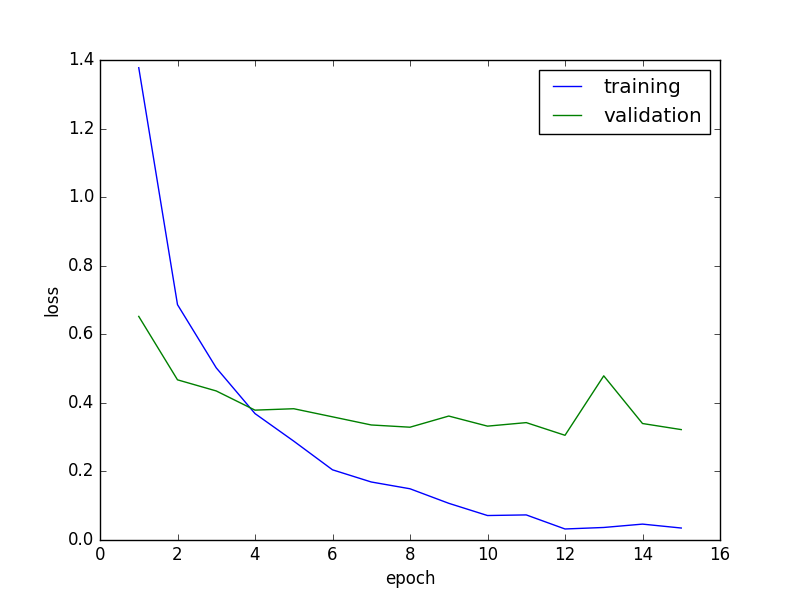

In [7]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(8, 6))
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

display(fig)

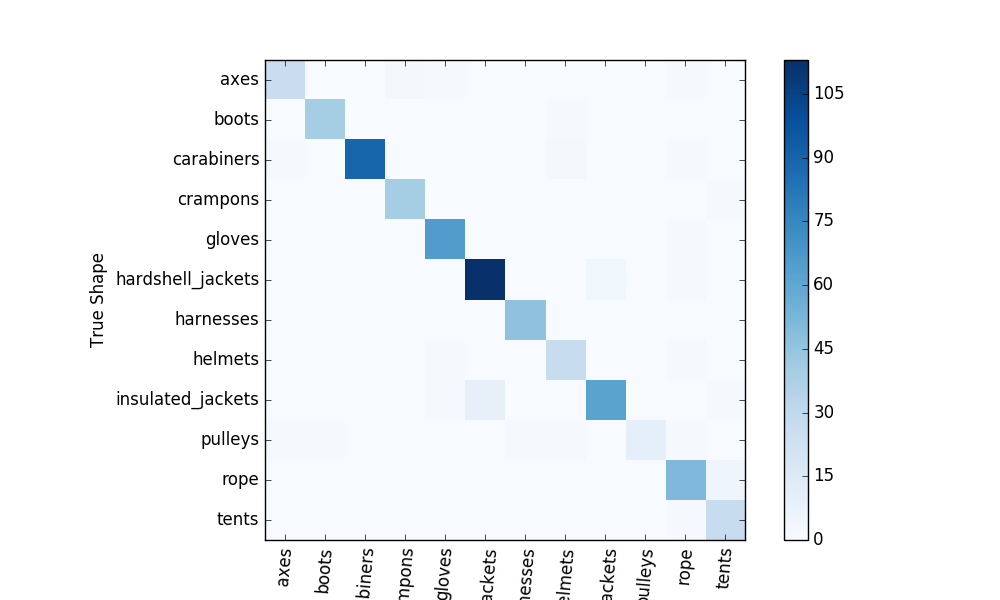

In [8]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.cpu().data.numpy():
        truelabels.append(label)
    for prediction in model.cpu()(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
fig = plt.figure(figsize=(10, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

display(fig)

In [9]:
# Helper function to resize image
def resize_image(img, size): 
    from PIL import Image, ImageOps 
    
    # Convert RGBA images to RGB
    if np.array(img).shape[2] == 4:
        img = img.convert('RGB')
        
    # resize the image
    img.thumbnail(size, Image.ANTIALIAS)
    newimg = Image.new("RGB", size, (255, 255, 255))
    newimg.paste(img, (int((size[0] - img.size[0]) / 2), int((size[1] - img.size[1]) / 2)))
  
    # return the resized image
    return newimg

# Function to predict
def predict_image(classifier, image):
    import numpy

    classifier.eval()
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)

    # Turn the input into a Variable
    input = Variable(image_tensor)

    # Predict the class of the image
    output = classifier(input)
    index = output.data.numpy().argmax()
    return index

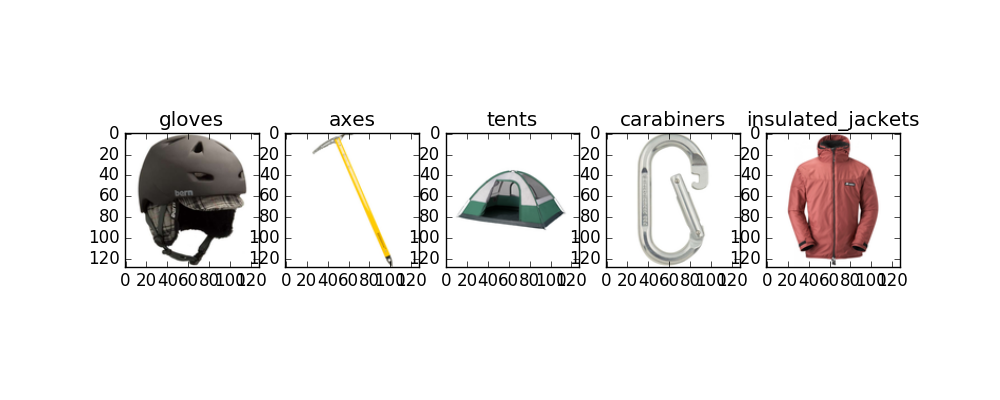

In [10]:
# Predict class for new data
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

image_urls = []
image_urls.append('https://i.stack.imgur.com/5I4Rx.jpg')
image_urls.append('https://i.stack.imgur.com/HeliW.jpg')
image_urls.append('https://productimages.camping-gear-outlet.com/e5/62379.jpg')
image_urls.append('http://s7d1.scene7.com/is/image/MoosejawMB/MIKAJMKFMKCAPNABx1024698_zm?$product1000$')
image_urls.append('http://www.buffalosystems.co.uk/wp-content/uploads/2012/06/zoom_apline_jacket_dark_russet-2365x3286.jpg')

size = (128,128)

fig = plt.figure(figsize=(10, 4))

# Get the images and show the predicted classes
for url_idx in range(len(image_urls)):
    # Get the image
    response = requests.get(image_urls[url_idx])
    img = Image.open(BytesIO(response.content))
    img = resize_image(img, size)
    class_idx = predict_image(model, img)
    class_name = classes[class_idx]
    a=fig.add_subplot(1,len(image_urls),url_idx+1)
    imgplot = plt.imshow(img)
    a.set_title(class_name)
    
display(fig)